In [1]:
import sys
import time
import random
import argparse
import math
import copy

from collections import defaultdict
import itertools

import numpy as np

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.tokenize import sent_tokenize, word_tokenize

import scipy.stats as stats
from statistics import mean

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sherry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read in Vocab

In [2]:
with open("./data/char-vocab-wiki-english", "r", encoding='utf-8') as inFile:
     itos = inFile.read().strip().split("\n")

print(itos)
stoi = dict([(itos[i],i) for i in range(len(itos))])

['!', '"', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'á', 'é', 'ö', '–', '—', '’']


## Model (Customized LSTM)

The analysis was performed on pre-trained Character-level LSTM proved by Michael Hahn and Marco Baroni [link](https://arxiv.org/abs/1906.07285). The model was reloaded on a customized LSTM to take the convenience of ablation methods designed in it, although we haven't conducted ablation anlaysis on CLSTM yet.

In [3]:
# Model Hyperparameter
VOCAB_SIZE = len(stoi)+3
HIDDEN_DIM = 1024
EMBEDDING_DIM = 200
CHAR_NOISE_PROB = 0

In [4]:
# Custom LSTM cell (single-layer) with ablation enabled
class LSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, inspect_gates=False):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # input gate
        self.W_ii = Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hi = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_i = Parameter(torch.Tensor(hidden_dim))
        # forget gate
        self.W_if = Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hf = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_f = Parameter(torch.Tensor(hidden_dim))
        # new cell candidate
        self.W_ic = Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_hc = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_c = Parameter(torch.Tensor(hidden_dim))
        # output gate
        self.W_io = Parameter(torch.Tensor(input_dim, hidden_dim))
        self.W_ho = Parameter(torch.Tensor(hidden_dim, hidden_dim))
        self.b_o = Parameter(torch.Tensor(hidden_dim))
        
        self.init_weights()
        
        self.inspect_gates = inspect_gates
        
        self.do_ablation = False
        self.ablated_neurons = []
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    # Initialize hidden state (a_0 and c_0) 
    def init_hidden(self):
        return (torch.zeros((1, self.hidden_dim)).to(device),
               torch.zeros((1, self.hidden_dim)).to(device))
    
    def ablate(self, layer, neurons):
        for n in neurons:
            layer[0][0][n] = 0
        return layer
    
    def forward(self, seq, hidden):
        seq_sz = seq.shape[0]
        h_t, c_t = hidden # receive input from the previous timestep
        
        h_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        c_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        c_tilde_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        i_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        o_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        f_seq = torch.zeros((0, 1, self.hidden_dim)).to(device)
        
        for t in range(seq_sz): # iterate over the time steps
            x_t = seq[t].unsqueeze(0) # input
            
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            o_t = torch.sigmoid(x_t @ self.W_io + h_t @ self.W_ho + self.b_o)
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            c_tilde_t = torch.tanh(x_t @ self.W_ic + h_t @ self.W_hc + self.b_c)
            c_t = f_t * c_t + i_t * c_tilde_t
            h_t = o_t * torch.tanh(c_t)
            
            # Ablation
            if self.do_ablation:
                c_t = self.ablate(c_t, self.ablated_neurons)
                h_t = self.ablate(h_t, self.ablated_neurons)
            
            h_seq = torch.cat((h_seq, h_t), dim=0)
            if self.inspect_gates:
                c_seq = torch.cat((c_seq, c_t), dim=0)
                c_tilde_seq = torch.cat((c_tilde_seq, c_tilde_t), dim=0)
                i_seq = torch.cat((i_seq, i_t), dim=0)
                o_seq = torch.cat((o_seq, o_t), dim=0)
                f_seq = torch.cat((f_seq, f_t), dim=0)
            
        if self.inspect_gates:
            return h_seq, [c_seq.reshape(seq_sz, self.hidden_dim)]
        
        return h_seq, [h_t, c_t]

In [5]:
# 3-layer LSTM
class LSTM(nn.Module):
    def __init__(self, vocab_size, char_embedding_dim, hidden_dim, inspect_gates=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_num = 3
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=char_embedding_dim)
        self.lstm0 = LSTMCell(char_embedding_dim, hidden_dim, inspect_gates)
        self.lstm1 = LSTMCell(hidden_dim, hidden_dim, inspect_gates)
        self.lstm2 = LSTMCell(hidden_dim, hidden_dim, inspect_gates)
        self.output = nn.Linear(hidden_dim, vocab_size)
        
    # Initialize hidden state (a_0 and c_0) 
    def init_hidden(self):
        return (torch.zeros((1, 1, self.hidden_dim)).to(device),
               torch.zeros((1, 1, self.hidden_dim)).to(device))
    
    def forward(self, seq, hidden0, hidden1, hidden2):
        # output contains outputs a_t for each t (for each time step)
        # There're 2 conditions for hidden: 
        # (1) a tuple that contains a_t and c_t for t=len(seq) (only the last time)
        # (2) a tuple of sequences of all hidden states and gates for each timestep
        embedded = self.embedding(seq)
        output0, hidden0 = self.lstm0(embedded, hidden0)
        output1, hidden1 = self.lstm1(output0, hidden1)
        output2, hidden2 = self.lstm2(output1, hidden2)
        output = self.output(output2.view(len(seq), -1))
        log_probs = F.log_softmax(output, dim=1)
        return log_probs, hidden0, hidden1, hidden2

# Reload Hahn's Model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model downloaded from https://github.com/m-hahn/tabula-rasa-rnns
checkpoint = torch.load("./data/wiki-english-nospaces-bptt-282506230.pth.tar",map_location=device)

In [7]:
model_state = {}
model_state["embedding.weight"] = checkpoint["char_embeddings"]["weight"]
model_state["output.weight"] = checkpoint["output"]["weight"]
model_state["output.bias"]= checkpoint["output"]["bias"]
for i in range(3):
    for start in ["i", "h"]:
        weight = checkpoint["rnn"]["weight_{}h_l{}_raw".format(start, i)]
        bias = checkpoint["rnn"]["bias_{}h_l{}".format(start, i)]
        
        # The orginal weights have dimension: hidden x input
        # Our model's weights have dimension: input x hidden
        model_state["lstm{}.W_{}i".format(i, start)] = torch.transpose(weight[:HIDDEN_DIM], 0, 1)
        model_state["lstm{}.W_{}f".format(i, start)] = torch.transpose(weight[HIDDEN_DIM: 2*HIDDEN_DIM], 0, 1)
        model_state["lstm{}.W_{}c".format(i, start)] = torch.transpose(weight[2*HIDDEN_DIM: 3*HIDDEN_DIM], 0, 1)
        model_state["lstm{}.W_{}o".format(i, start)] = torch.transpose(weight[3*HIDDEN_DIM:], 0, 1)
        
        model_state["lstm{}.b_i".format(i, start)] = bias[:HIDDEN_DIM]
        model_state["lstm{}.b_f".format(i, start)] = bias[HIDDEN_DIM: 2*HIDDEN_DIM]
        model_state["lstm{}.b_c".format(i, start)] = bias[2*HIDDEN_DIM: 3*HIDDEN_DIM]
        model_state["lstm{}.b_o".format(i, start)] = bias[3*HIDDEN_DIM:]

In [8]:
model = LSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model.load_state_dict(model_state)
model.eval()

LSTM(
  (embedding): Embedding(63, 200)
  (lstm0): LSTMCell()
  (lstm1): LSTMCell()
  (lstm2): LSTMCell()
  (output): Linear(in_features=1024, out_features=63, bias=True)
)

# Helper Methods

In [9]:
def get_hidden(seq_tensor, model): # Hidden instead of cell states
    with torch.no_grad():
        hidden0 = model.init_hidden()
        hidden1 = model.init_hidden()
        hidden2 = model.init_hidden()
        model.lstm0.inspect_gates = True
        model.lstm1.inspect_gates = True
        model.lstm2.inspect_gates = True
        log_probs, hidden0, hidden1, hidden2 = model(seq_tensor, hidden0, hidden1, hidden2)
        cell_state0 = hidden0[0].cpu()
        cell_state1 = hidden1[0].cpu()
        cell_state2 = hidden2[0].cpu()
        model.lstm0.inspect_gates = False
        model.lstm1.inspect_gates = False
        model.lstm2.inspect_gates = False
    return [cell_state0, cell_state1, cell_state2]

## Sequence Processing

In [10]:
def load_text(file):
    text = ''
    with open(file, "r", encoding='utf-8') as inFile:
        for line in inFile:
            text = text + line.strip().lower() + ' '
        return text

In [11]:
def words_to_chars(words):
    chars = []
    for w in words:
        chars += list(w)
    return chars

In [12]:
def char2int(char_seq, stoi, itos):
    int_seq = []
    for char in char_seq:
        int_seq.append((stoi[char]+3 if char in stoi else 2) \
                       if random.random() > CHAR_NOISE_PROB \
                       else 2+random.randint(0, len(itos)))
    return torch.tensor(int_seq).to(device)

In [13]:
def sents_to_chars(sents):
    chars = []
    for s in sents:
        for w in word_tokenize(s):
            chars += list(w)
    return chars

## Consturction Analysis

In [14]:
def construction_analysis(shared_input, intact_context, scrambled_context, all_mean, all_std, model, stoi, itos): # chunk = preprocessed chars
    
    intact_array = char2int(intact_context + shared_input, stoi, itos)
    scrambled_array = char2int(scrambled_context + shared_input, stoi, itos)
    
    hidden_intact = get_hidden(intact_array, model)
    hidden_scrambled = get_hidden(scrambled_array, model)
        
    corr_all = []
    diff_all = []
    
    for layer in range(3):
        # Normalize activation
        mean = all_mean[layer]
        std = all_std[layer]
        normalized_intact = (hidden_intact[layer] - mean) / std
        normalized_scrambled = (hidden_scrambled[layer] - mean) / std
        
        corr_array = np.zeros(0)

        # Calculate correlation at each timestep
        for i in range(VIEW_LENGTH):
            corr = np.corrcoef(normalized_intact[-VIEW_LENGTH + i], normalized_scrambled[-VIEW_LENGTH + i])[0][1]
            corr_array = np.append(corr_array, corr)

        # Activation diff (single unit)
        diff = np.abs(normalized_scrambled[-VIEW_LENGTH:] - normalized_intact[-VIEW_LENGTH:])
    
        corr_all.append(corr_array)
        diff_all.append(diff.T)
        
    return corr_all, diff_all

In [15]:
# Curve fitting methods
def CI(alpha, data):
    CI=stats.norm.interval(alpha, loc=np.mean(data), scale=stats.sem(data))
    
    return (CI[1]-CI[0])/2

from scipy.optimize import curve_fit
def curve_tanh(x,a,b,c):
    return a*np.tanh(b*x)
def curve_logistic(x,a,b,c,d):
    return (a-d)/(1+np.exp(-b*(x-c))) + d


def alignment_time(k,b,c):
    return(1/b)*np.log(k/(1-k))+c
def align_time_threshold(y,a,b,c,d):
    return np.log(a/(y-d)-1)/(-b)+c

# Comma-And Context Construction (Novel)


Feed in the whole corpus into the model and calculate the activation mean and standard deviation. Load saved data here.

In [16]:
# Novel corpus
corpus = load_text("./data/anna.txt")
corpus_sents = sent_tokenize(corpus)
corpus_chars = sents_to_chars(corpus_sents)
corpus_sents_chars = [list(''.join(s.split())) for s in corpus_sents]

In [17]:
all_mean = torch.from_numpy(np.load("./activations/clstm/all_mean_novel.npy")).clone().detach()
all_std = torch.from_numpy(np.load("./activations/clstm/all_std_novel.npy")).clone().detach()

## Timescale Measurement

In [18]:
# Construction analysis hyperparameters
total_sents_num = len(corpus_sents)
PERMU = 25
TRIAL_NUM = 77
CONTEXT_LENGTH = 33
SHARED_LENGTH = 80 # different sentences have different length
VIEW_LENGTH = CONTEXT_LENGTH + SHARED_LENGTH

We read in and tokenize the same "comma-and" sentences used in WLSTM analysis. The subsentence preceding ", and" is considered as context while the remaining sentence with ", and" is the shared input.

In [19]:
intact_shared_sents = np.load("./data/anna_sents_shared.npy")
intact_context_sents = np.load("./data/anna_sents_context.npy")
scrambled_pool_sents = np.load("./data/scamble_pool_sentence.npy")

In [20]:
intact_context_array = []
intact_shared_array = []
for i in range(len(intact_shared_sents)):
    intact_shared_array.append(sents_to_chars(intact_shared_sents[i].lower()))
    intact_context_array.append(sents_to_chars(intact_context_sents[i].lower()))

In [21]:
scrambled_pool = [list(''.join(s.lower().split())) for s in scrambled_pool_sents]
scrambled_pool = [s for s in scrambled_pool if len(s)>50]

In [ ]:
# Construction analysis code
all_corr0 = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))
all_diff0 = np.zeros((TRIAL_NUM, PERMU,HIDDEN_DIM, VIEW_LENGTH))
all_corr1 = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))
all_diff1 = np.zeros((TRIAL_NUM, PERMU,HIDDEN_DIM, VIEW_LENGTH))
all_corr2 = np.zeros((TRIAL_NUM, PERMU, VIEW_LENGTH))
all_diff2 = np.zeros((TRIAL_NUM, PERMU,HIDDEN_DIM, VIEW_LENGTH))

for i in range(TRIAL_NUM):
    shared_input = intact_shared_array[i][:SHARED_LENGTH]
    intact_context = intact_context_array[i]
    
    # Randomly pick the preceding context
    scrambles_samples = np.random.choice(scrambled_pool, PERMU, replace=False)

    for p in range(PERMU):
        scrambled_context = scrambles_samples[p]
        corr, diff = construction_analysis(shared_input, intact_context, scrambled_context,\
                                               all_mean, all_std, model, stoi, itos)
        all_corr0[i, p] = corr[0]
        all_diff0[i, p] = diff[0]
        all_corr1[i, p] = corr[1]
        all_diff1[i, p] = diff[1]
        all_corr2[i, p] = corr[2]
        all_diff2[i, p] = diff[2]

In [ ]:
# (1) Average over permutations within trial
# (2) Average over trials
average_corr01 = np.average(all_corr0, axis=1)
average_diff01 = np.average(all_diff0, axis=1)
average_corr02 = np.average(average_corr01, axis=0)
average_diff02 = np.average(average_diff01, axis=0)

average_corr11 = np.average(all_corr1, axis=1)
average_diff11 = np.average(all_diff1, axis=1)
average_corr12 = np.average(average_corr11, axis=0)
average_diff12 = np.average(average_diff11, axis=0)

average_corr21 = np.average(all_corr2, axis=1)
average_diff21 = np.average(all_diff2, axis=1)
average_corr22 = np.average(average_corr21, axis=0)
average_diff22 = np.average(average_diff21, axis=0)

In [41]:
# Load saved data
average_corr01 = np.load('./results/clstm/novel/mean_corr01.npy')
average_corr02 = np.load('./results/clstm/novel/mean_corr02.npy')
average_corr11 = np.load('./results/clstm/novel/mean_corr11.npy')
average_corr12 = np.load('./results/clstm/novel/mean_corr12.npy')
average_corr21 = np.load('./results/clstm/novel/mean_corr21.npy')
average_corr22 = np.load('./results/clstm/novel/mean_corr22.npy')

average_diff02 = np.load('./results/clstm/novel/mean_diff02.npy')
average_diff12 = np.load('./results/clstm/novel/mean_diff12.npy')
average_diff22 = np.load('./results/clstm/novel/mean_diff22.npy')

## Layer correlation alignment during context construction

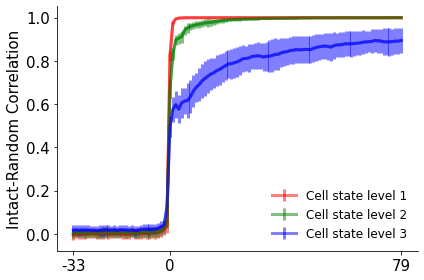

In [23]:
CONTEXT_LENGTH=33
SHARED_LENGTH=80
SCALE = CONTEXT_LENGTH+SHARED_LENGTH

VIEW_LENGTH=CONTEXT_LENGTH+SHARED_LENGTH
plt.errorbar(range(SCALE),np.mean(average_corr01,0), yerr = np.std(average_corr01,0),
             c='r', alpha=0.5,label='Cell state level 1',lw=3)
plt.plot(range(SCALE),np.mean(average_corr01,0), c='r', alpha=0.5,lw=3)

plt.errorbar(range(SCALE),np.mean(average_corr11,0), yerr = np.std(average_corr11,0),
             c='g', alpha=0.5, label='Cell state level 2',lw=3)
plt.plot(range(SCALE),np.mean(average_corr11,0), c='g', alpha=0.5,lw=3)

plt.errorbar(range(SCALE),np.mean(average_corr21,0), yerr = np.std(average_corr21,0),
             c='b', alpha=0.5, label='Cell state level 3',lw=3)
plt.plot(range(SCALE),np.mean(average_corr21,0), c='b', alpha=0.5,lw=3)

plt.xticks([0, CONTEXT_LENGTH, VIEW_LENGTH-1], [-CONTEXT_LENGTH, 0, SHARED_LENGTH-1])
plt.ylabel("Intact-Random Correlation", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12,frameon=False,loc='lower right')

plt.tight_layout()
plt.show()

## Logistic fitting of activation differences

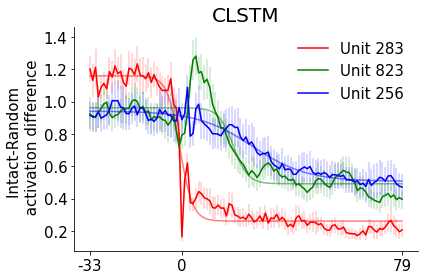

In [42]:
CONTEXT_LENGTH = 33
SHARED_LENGTH = 80
VIEW_CONTEXT = 33 # length of context tail included to view and fit
xdata=np.arange(-VIEW_CONTEXT,SHARED_LENGTH)
SCALE = VIEW_CONTEXT+SHARED_LENGTH
COLORS = ['r', 'g', 'b']
UNITS = [283,823,256]
fig, ax = plt.subplots()

for i in range(len(UNITS)):
    unit = UNITS[i]
    c = COLORS[i]
    popt1,pcov=curve_fit(curve_logistic,xdata,average_diff22[unit,CONTEXT_LENGTH-VIEW_CONTEXT:CONTEXT_LENGTH+SHARED_LENGTH], maxfev=5000)

    plt.plot(range(SCALE), average_diff22[unit,CONTEXT_LENGTH-VIEW_CONTEXT:CONTEXT_LENGTH+SHARED_LENGTH], color=c, label="Unit {}".format(unit))
    plt.errorbar(range(SCALE),average_diff22[unit,CONTEXT_LENGTH-VIEW_CONTEXT:CONTEXT_LENGTH+SHARED_LENGTH], CI(0.95,average_diff21[:,unit, CONTEXT_LENGTH-VIEW_CONTEXT:CONTEXT_LENGTH+SHARED_LENGTH]), color=c, alpha=0.2)    
    plt.plot(range(SCALE),curve_logistic(xdata, *popt1),color=c,alpha=0.5)
plt.yticks(fontsize=15)   
ax.set_ylabel('Intact-Random \n activation difference', size=15)
plt.xticks([0,VIEW_CONTEXT, VIEW_CONTEXT+SHARED_LENGTH-1], [-VIEW_CONTEXT, 0, SHARED_LENGTH-1], size=15)

plt.legend(fontsize=15,loc='upper right', bbox_to_anchor=(1, 1),frameon=False)
plt.title('CLSTM',size=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.show()

## Fit logistic curves and find the timescale for every unit

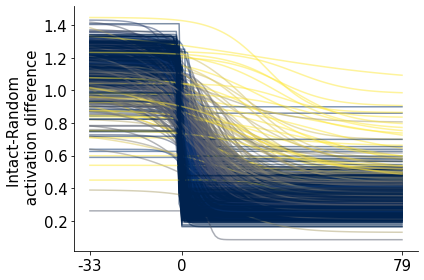

In [43]:
# Fit logistic curve and find timescale
import warnings
warnings.filterwarnings('ignore')

CONTEXT_LENGTH=33
SHARED_LENGTH=80
asymptote={}
construction_time={}
no_fit=[]

VIEW_LENGTH=CONTEXT_LENGTH+SHARED_LENGTH

import matplotlib.cm as cm

for i in range(HIDDEN_DIM):
    try:
        popt1,pcov=curve_fit(curve_logistic,xdata,average_diff22[i],maxfev=5000)
        mid=curve_logistic(xdata, *popt1)[CONTEXT_LENGTH]- \
            ((curve_logistic(xdata, *popt1)[CONTEXT_LENGTH]-(curve_logistic(xdata, *popt1)[VIEW_LENGTH-1]))/2)
        for j in range(len(curve_logistic(xdata, *popt1))-1):
            # time-to-half-maximum: see equation 2 in section 5 for details
            if curve_logistic(xdata, *popt1)[j]>mid and \
                curve_logistic(xdata, *popt1)[j+1]<mid and \
                j>CONTEXT_LENGTH-1:
                
                construction_time[i]=j-CONTEXT_LENGTH
                asymptote[i]=curve_logistic(xdata, *popt1)[15]
                color=(j-CONTEXT_LENGTH)/30
                
                plt.plot(range(SCALE),curve_logistic(xdata, *popt1), alpha=0.5,c=cm.cividis(color))
                plt.xticks([0, CONTEXT_LENGTH, SHARED_LENGTH+CONTEXT_LENGTH-1], [-CONTEXT_LENGTH, 0, SHARED_LENGTH-1],size=15)
                plt.yticks(size=15)
                plt.ylabel('Intact-Random \n activation difference', fontsize=15)
                ax=plt.gca()

                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)

    except:
        no_fit.append(i)
        pass 

plt.tight_layout()
plt.show()

In [26]:
# Sort units based on their timescales
sorted_time=sorted(construction_time.items(), key=lambda item: item[1],reverse=True)
sorted_cells=[]
sorted_timescale=[]
for i in sorted_time:
    sorted_cells.append(i[0])
    sorted_timescale.append(i[1])

## Heatmap view of all units' activation 

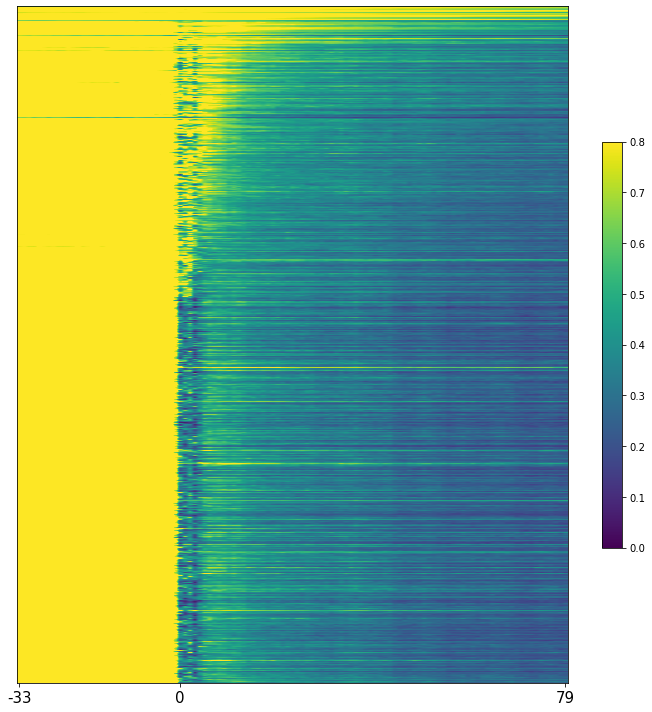

In [27]:
CONTEXT_LENGTH=33
SHARED_LENGTH=80
FIT_SHARED = SHARED_LENGTH
FIT_CONTEXT = CONTEXT_LENGTH

xdata=np.arange(-FIT_CONTEXT,FIT_SHARED)
SCALE = FIT_CONTEXT+FIT_SHARED
pos=[]
cell_pos=[]

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
poss=ax1.imshow(average_diff22[sorted_cells],aspect="auto",vmin=0, vmax=0.8)

ax1.set_yticks(pos) 
ax1.set_yticklabels(cell_pos,size=15) 

ax1.set_xticks([0,FIT_CONTEXT, FIT_CONTEXT+FIT_SHARED-1])
ax1.set_xticklabels([-FIT_CONTEXT, 0, FIT_SHARED-1], size=15)

fig.colorbar(poss, shrink=0.6)
plt.tight_layout()
plt.show()

## Network Analysis

In [28]:
import networkx as nx

In [29]:
w_if = model_state['lstm2.W_if'].cpu()
w_hf = model_state['lstm2.W_hf'].cpu()
w_ii = model_state['lstm2.W_ii'].cpu()
w_hi = model_state['lstm2.W_hi'].cpu()

### Significant Projection

In [30]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

# concatenate projection to input and forget gate
w_hf_hi = torch.cat((w_hi,w_hf),1)
w_hf_hi_sim = euclidean_distances(w_hf_hi.detach().numpy())

In [31]:
def significant_weight_connection(weight_hidden2gate):
    sig_conn_all=[]
    sig_conn_number=[]
    z_connection=np.zeros((weight_hidden2gate.size()[0],weight_hidden2gate.size()[1]))
    for from_cell in range(weight_hidden2gate.size()[0]):
        sig_conn=[]
        for to_cell in range(weight_hidden2gate.size()[1]):
            z = (weight_hidden2gate[from_cell,to_cell]-weight_hidden2gate[from_cell,:].mean())/weight_hidden2gate[from_cell,:].std()
            z_connection[from_cell][to_cell]=abs(z)
            if abs(z)>5:
                sig_conn.append(to_cell)
        sig_conn_all.append(sig_conn)
        sig_conn_number.append(len(sig_conn))
    return sig_conn_all, sig_conn_number,z_connection

In [32]:
# Get significant connections to input/forget gate
sig_conn_all_whf, sig_conn_number_whf, z_whf=significant_weight_connection(w_hf)
sorted_sig_conn_number_whf=[]
for i in sorted_cells:
    sorted_sig_conn_number_whf.append(sig_conn_number_whf[i])

sig_conn_all_whi, sig_conn_number_whi, z_whi=significant_weight_connection(w_hi)
sorted_sig_conn_number_whi=[]
for i in sorted_cells:
    sorted_sig_conn_number_whi.append(sig_conn_number_whi[i])

### K-core Analysis

In [33]:
def insert_edges_by_sig_conn(graph, sig_conn):
    for i in range(len(sig_conn)):
        for j in range(len(sig_conn[i])):
            if i!=sig_conn[i][j]:
                graph.add_edge(i,sig_conn[i][j])

In [34]:
# Assign color scale of each unit by timescale
node_color=[]
for i in range(len(w_hf_hi_sim)):
    if i in sorted_cells:
        node_color.append(sorted_time[sorted_cells.index(i)][1])
    else:
        node_color.append(0)

node_color_normalize=[0]*len(node_color)
for i in range(len(node_color)):
    if round((node_color[i]-min(node_color))/(15-min(node_color)),1)>1:
        node_color_normalize[i]=1
    else:
        node_color_normalize[i]=round((node_color[i]-min(node_color))/(30-min(node_color)),1)

In [35]:
sig_conn_all_whihf = []
for i in range(len(sig_conn_all_whi)):
    sig_conn_all_whihf.append(sig_conn_all_whf[i]+sig_conn_all_whi[i])

#construct network by significant projections from hidden units to input gate + forget gate (i.e. |z|>5)
G=nx.DiGraph()
insert_edges_by_sig_conn(G, sig_conn_all_whihf)

#find k projections from hidden units to input gate + forget gate in the weight matrices
w_hf_hi_numpy=w_hf_hi.detach().numpy()
w_hf_hi_flatten=w_hf_hi_numpy.flatten()
w_hf_hi_flatten_sort=np.argsort(abs(w_hf_hi_flatten))[::-1]

from_unit=[]
to_unit=[]
i=0
while i < len(G.edges()):
    fu = w_hf_hi_flatten_sort[i]//2048
    tu = w_hf_hi_flatten_sort[i]%2048
    if tu > 1023:
        tu -= 1024
    if tu!=fu:
        from_unit.append(fu)
        to_unit.append(tu)
    i+=1

edges=[]
for i in range(len(to_unit)):
    edges.append((from_unit[i],to_unit[i]))

#construct network by the top k projections from hidden units to input gate + forget gate in the weight matrices
G2=nx.DiGraph()
G2.add_edges_from(edges)
k_core_G_Whfhi2 = nx.algorithms.core.k_core(G2, k=4, core_number=None)

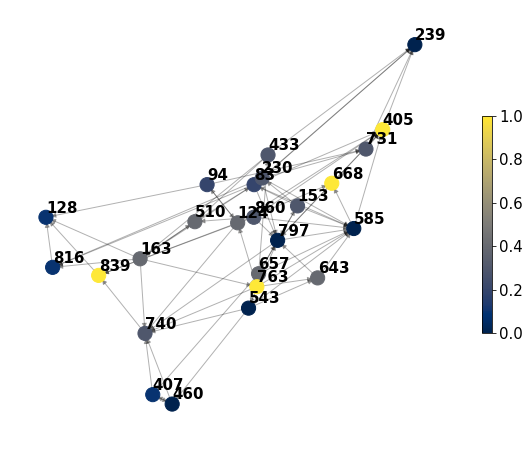

In [36]:
import matplotlib.cm as cm
core_units2=k_core_G_Whfhi2.nodes()

core_node_color2=[]
for i in core_units2:
    core_node_color2.append(node_color_normalize[i])


cmap = cm.cividis
plt.figure(figsize=(10,8))
pos=nx.spring_layout(k_core_G_Whfhi2)

nodes=nx.draw_networkx(k_core_G_Whfhi2,pos,node_size=100, cmap = cmap,with_labels=False,\
                       node_color=core_node_color2,alpha=0.3)

nx.draw_networkx_nodes(k_core_G_Whfhi2,pos, nodelist=None, node_size=200, cmap = cmap, node_color=core_node_color2,node_shape='o',vmax=1,vmin=0)

for i in k_core_G_Whfhi2.nodes():
    x,y=pos[i]
    plt.text(x,y+0.01,s=i, size=15,weight='bold')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])


cbar = plt.colorbar(sm, shrink=0.5)
cbar.ax.tick_params(labelsize=15) 

plt.axis('off')
plt.show()

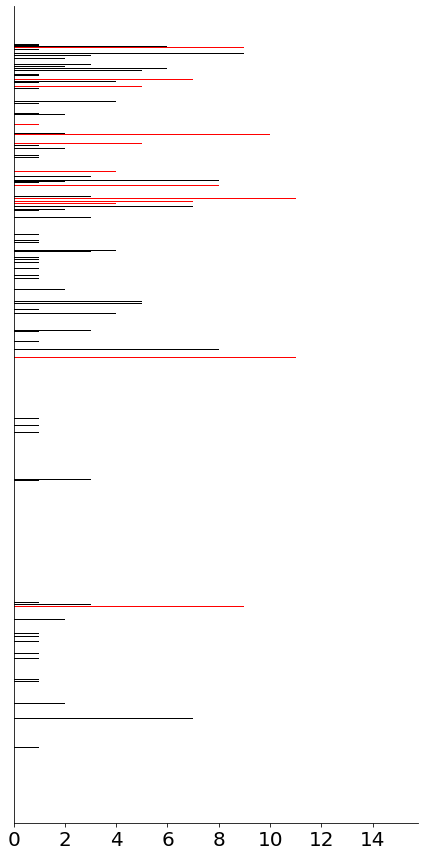

In [37]:
sorted_sig_conn_number_whfhi=[sum(x) for x in zip(sorted_sig_conn_number_whf, sorted_sig_conn_number_whi)]
fig, ax = plt.subplots(figsize=(6,12))

# Example data
cell = sorted_cells
y_pos = np.arange(len(sorted_cells))
strength = sorted_sig_conn_number_whfhi
colors=['k']*(len(sorted_sig_conn_number_whfhi))
for i in core_units2:
    if i in cell:
        colors[cell.index(i)]='r'
ax.barh(y_pos, strength, align='center',color=colors)

ax.invert_yaxis()  # labels read top-to-bottom
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pos=[]
cell_pos=[]

plt.xticks(size=20)
plt.yticks([])
ax.set_yticks(pos)
ax.set_yticklabels(cell_pos,size=10,weight='bold',color='r') 
# ax.set_xlabel('Significant connections from hidden unit to input+forget gate ', size=15)
# ax.set_ylabel('Unit sorted by timescale', size=1)
plt.tight_layout()
plt.show()

### MDS

In [38]:
sorted_sig_conn_whihf=[sum(x) for x in zip(sorted_sig_conn_number_whf, sorted_sig_conn_number_whi)]
sig_conn_hihf=[sum(x) for x in zip(sig_conn_number_whi, sig_conn_number_whf)]

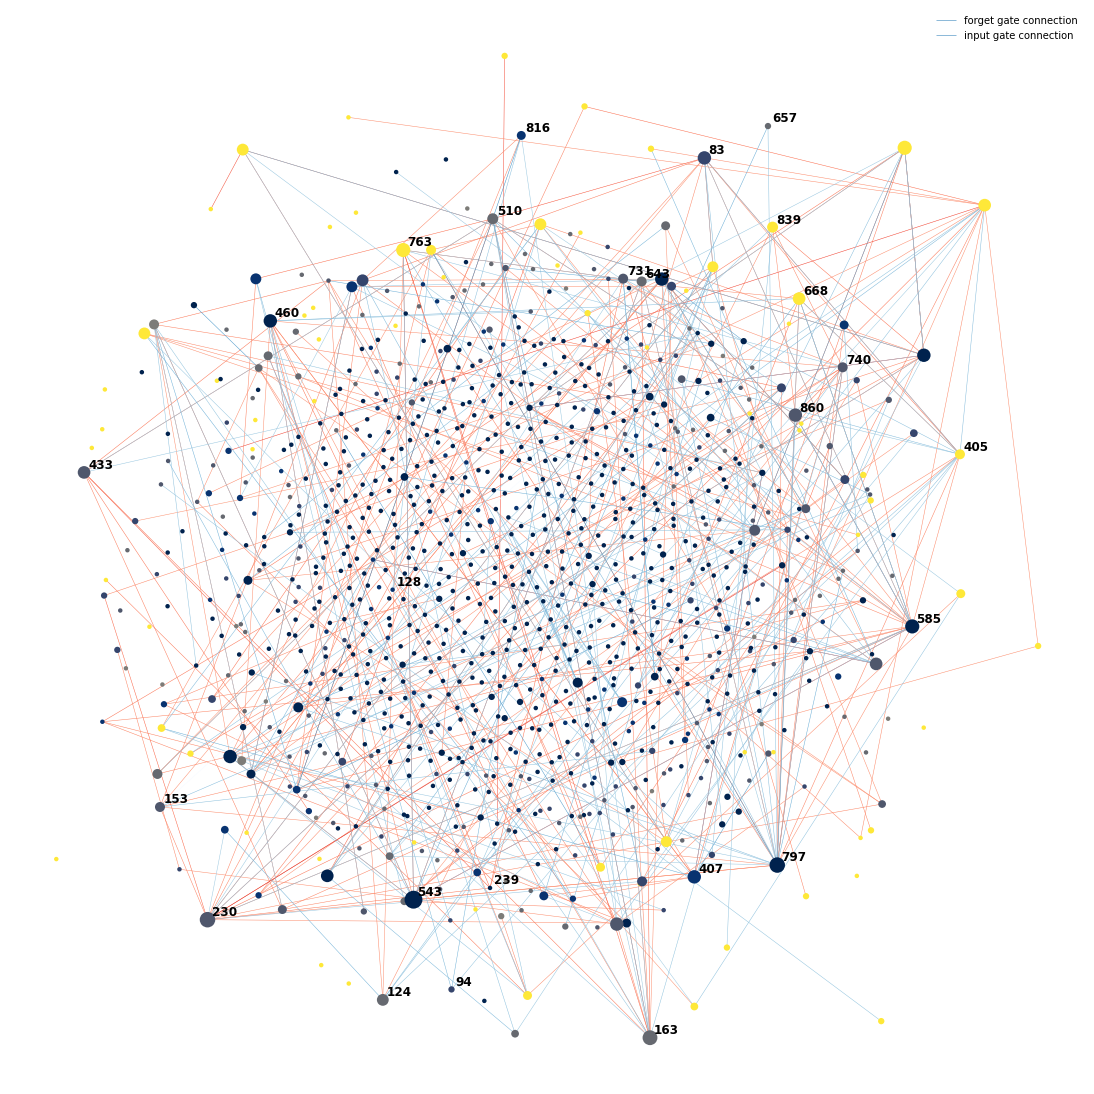

In [39]:
import matplotlib.cm as cm
seed = np.random.RandomState(seed=3)


mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
poss = mds.fit(w_hf_hi_sim).embedding_


# # Rotate the data
clf = PCA(n_components=2)

poss = clf.fit_transform(poss)

fig = plt.figure(figsize=(15,15))
ax = plt.axes([0., 0., 1., 1.])

cmap = cm.cividis
s_arr=[x*20+20 for x in sig_conn_hihf]

plt.scatter(poss[:, 0], poss[:, 1], c=node_color_normalize, s=s_arr,cmap=cmap,lw=0)

for unit in core_units2:
    plt.text(poss[unit,0]+0.1,poss[unit,1]+0.1,s=str(unit), size=12,weight='bold')
    
segments = [[poss[i, :], poss[j, :]]
            for i in range(len(poss)) for j in sig_conn_all_whf[i]]

segments2 = [[poss[i, :], poss[j, :]]
            for i in range(len(poss)) for j in sig_conn_all_whi[i]]

lc = LineCollection(segments,zorder=0, cmap=plt.cm.Reds, label='forget gate connection')
lc2 = LineCollection(segments2,zorder=0, cmap=plt.cm.Blues, label='input gate connection')


lc.set_array(w_hf_hi_sim.flatten())
lc2.set_array(w_hf_hi_sim.flatten())

lc.set_linewidths(np.full(len(segments), 0.5))
lc2.set_linewidths(np.full(len(segments2), 0.5))

ax.add_collection(lc)
ax.add_collection(lc2)

plt.axis('off')

plt.legend(frameon=False)
plt.show()